# Feed-forward сети

Итак, давайте потренируемся тренировать нейронные сети прямого распространения (так как делали на паре)
При этом попробуем создать свою функцию активации на одном из слоев

### Сделаем необходимые импорты

In [1]:
import torch
import numpy as np

from torch import nn
import torchvision

import torch.nn.functional as F

from torch import optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.autograd import Variable

### Загрузим датасет CIFAR-100, сразу же создадим dataloader для него

Если вам не хватает вычислительных ресурсов, то можно вернуться к CIFAR-10

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=True)




Files already downloaded and verified


In [4]:
image, label = train_dataset[0]
print (image.size())
print (label)

torch.Size([3, 32, 32])
6


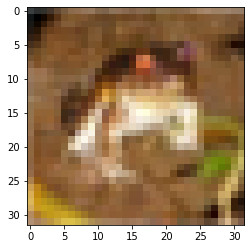

In [5]:
plt.imshow(image.permute(1, 2, 0).numpy())

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

In [7]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False)

Files already downloaded and verified


In [8]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Создайте собственную архитектуру! Можете использовать все, что угодно, но в ограничении на использование линейные слои (пока без сверток)

Давайте добавим ограниченный Leaky_relu, то есть output = max(0.1x, 0.5x)
Ваша задача добавить его в архитектуру сети как функцию активации

(На сколько я понял, функция активации - лишь пример и не дает дополнительного прироста в вычислениях)

In [24]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.cut_relu(x)
        x = self.fc2(x)
        x = self.cut_relu(x)
        return x
        
    # Функция активации
    def cut_relu(self, x):
        x01 = 0.1*x
        x05 = 0.5*x
        m = torch.stack([x01,x05],dim=1)
        #return F.relu(x, 0.05)
        return torch.amax(m, dim=1)

### Запустить обучение (по аналогии с тем, что делали на паре)

In [26]:
net = Net(3072, 100, 10)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [29]:
for epoch in tqdm(range(10)):  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Training is finished!')

  0%|                                                    | 0/10 [00:00<?, ?it/s]

[1,     1] loss: 0.001
[1,   301] loss: 0.344
[1,   601] loss: 0.341


 10%|████▍                                       | 1/10 [00:08<01:14,  8.33s/it]

[2,     1] loss: 0.001
[2,   301] loss: 0.330
[2,   601] loss: 0.322


 20%|████████▊                                   | 2/10 [00:16<01:04,  8.06s/it]

[3,     1] loss: 0.001
[3,   301] loss: 0.312
[3,   601] loss: 0.305


 30%|█████████████▏                              | 3/10 [00:24<00:56,  8.03s/it]

[4,     1] loss: 0.001
[4,   301] loss: 0.299
[4,   601] loss: 0.296


 40%|█████████████████▌                          | 4/10 [00:32<00:48,  8.01s/it]

[5,     1] loss: 0.001
[5,   301] loss: 0.293
[5,   601] loss: 0.289


 50%|██████████████████████                      | 5/10 [00:40<00:41,  8.20s/it]

[6,     1] loss: 0.001
[6,   301] loss: 0.287
[6,   601] loss: 0.284


 60%|██████████████████████████▍                 | 6/10 [00:49<00:33,  8.45s/it]

[7,     1] loss: 0.001
[7,   301] loss: 0.283
[7,   601] loss: 0.282


 70%|██████████████████████████████▊             | 7/10 [00:58<00:25,  8.55s/it]

[8,     1] loss: 0.001
[8,   301] loss: 0.279
[8,   601] loss: 0.279


 80%|███████████████████████████████████▏        | 8/10 [01:06<00:16,  8.42s/it]

[9,     1] loss: 0.001
[9,   301] loss: 0.277
[9,   601] loss: 0.276


 90%|███████████████████████████████████████▌    | 9/10 [01:15<00:08,  8.64s/it]

[10,     1] loss: 0.001
[10,   301] loss: 0.275
[10,   601] loss: 0.275


100%|███████████████████████████████████████████| 10/10 [01:24<00:00,  8.45s/it]

Training is finished!


### Попытка проверки качества обучения на примере

Переведем в рабочий режим

In [30]:
net.eval()

Net(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

Возьмем одно изображение

In [32]:
input_d, label_d = train_dataset[0]

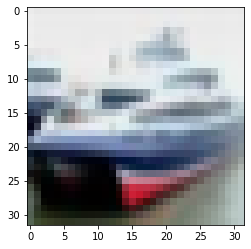

In [34]:
plt.imshow(test_dataset[1][0].permute(1, 2, 0))

Получаем тензор данных из одного изображения

In [36]:
data = Variable(test_dataset[1][0].reshape(1,-1))

In [37]:
data.size()

torch.Size([1, 3072])

In [38]:
xdata = data.view(data.shape[0], -1)

In [39]:
xdata

tensor([[0.9216, 0.9059, 0.9098,  ..., 0.6980, 0.7490, 0.7804]])

In [40]:
net.fc1(xdata)

tensor([[ 3.2224, -0.7414,  3.8875, -1.5343,  1.4818,  6.0632,  3.6357,  0.8069,
          3.8417,  1.0515,  3.6926, -1.4590, -0.3277,  6.5869, -0.2271,  1.0427,
          4.4185,  1.4245,  3.9188, -0.9864,  5.5171,  2.5391,  0.8226,  3.9453,
          3.7589, -0.7512,  5.0132,  1.8418,  0.9567,  2.9718,  1.4569, -0.4996,
         -1.0216,  1.7059,  3.9131,  1.1219, -0.5763,  1.4370,  2.2543,  0.1803,
          7.4068, -1.3329,  4.8518,  2.2108, -1.2489,  5.0875,  3.2766,  3.2462,
          1.3203, -0.5546,  2.6085, -0.8580,  1.7261,  5.0174,  1.7132, -1.4230,
          0.2812,  2.7118,  1.5273,  3.0877,  0.8894,  1.4046,  5.0521,  0.9083,
          3.0570, -0.3035,  3.5705,  5.3209,  2.1341,  6.8110,  2.2933,  4.6795,
         -0.1527,  4.2255,  0.5259,  1.8984,  2.2282,  4.4684, -0.2207,  0.7184,
          5.5111,  7.2771,  3.1609,  0.1700, -0.3613,  1.8853,  2.1667,  1.0621,
          7.2577,  2.1032, -1.5477,  4.3478,  3.7498, -0.1505,  3.3265,  0.9958,
         -1.4817,  3.1469,  

Проверяем работу сети. Качество (на примере одной картинки) получается не очень. (Relu на этой картинке справилось)

In [77]:
net(xdata)

tensor([[2.8956, 3.1944, 0.0000, 0.6344, 0.1046, 0.6798, 0.0000, 0.9942, 5.3935,
         4.2490]], grad_fn=<ReluBackward0>)

In [78]:
torch.save(net, 'cifar10.pt')